## 1. Where are the old left-handed people?

<p>Barack Obama, Bill Gates, Oprah Winfrey, Babe Ruth, and Marie Curie are notable left-handed individuals. A <a href="https://www.nejm.org/doi/full/10.1056/NEJM199104043241418">1991 study</a> suggested left-handed people die nine years earlier than right-handed ones. We will examine this claim using age distribution data, employing <code>pandas</code> and Bayesian statistics to analyze death ages in relation to left or right hand dominance.</p>
<p>In 1986, a National Geographic survey gathered data on age, sex, and hand preference from over a million participants. Researchers Gilbert and Wysocki found that left-handedness rates varied with age due to changing social norms. This variation is more about the birth year rather than age itself. We will explore the impact of these changing rates on the average death age of left-handed people, starting with an analysis of left-handedness rates by age.</p>
<p>This motivated me to a run a project to analyze the probability differences of death in left handed people and right handed people, cheecking whether the discrepency is really caused by left handed, and whether the discrepency actually exists. </p>
<p>Our analysis uses two datasets: <a href="https://www.cdc.gov/nchs/data/statab/vs00199_table310.pdf">1999 U.S. death distribution data</a> (source <a href="https://www.cdc.gov/nchs/nvss/mortality_tables.htm">here</a>) and left-handedness rates from a <a href="https://www.ncbi.nlm.nih.gov/pubmed/1528408">1992 study by Gilbert and Wysocki</a>.</p>


<ipython-input-44-87177a24c6ea>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # Using seaborn style for better aesthetics


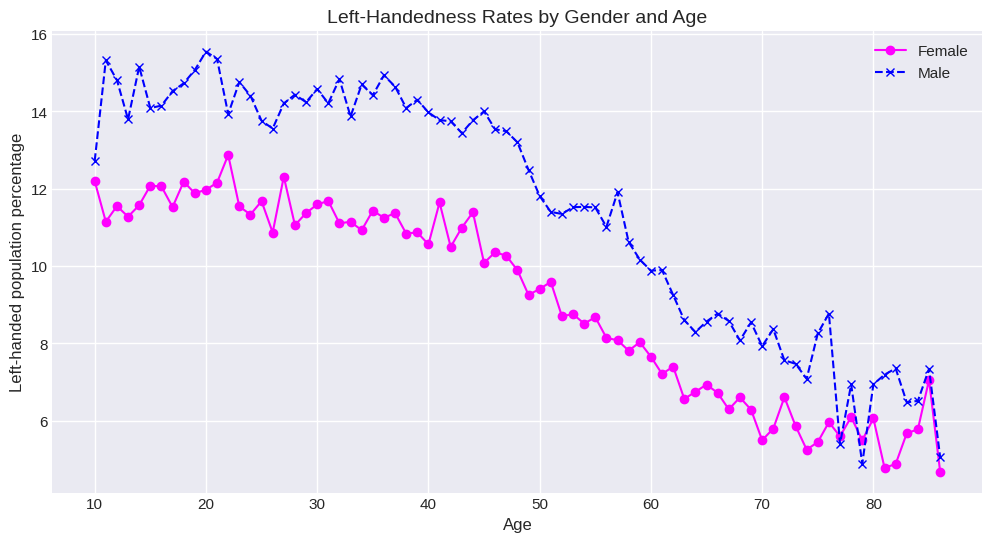

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace with your actual data URL
file1 = "death_distribution_data.csv"
lefthanded_data = pd.read_csv(file1)

# Plotting male and female left-handedness rates vs. age
plt.style.use('seaborn-darkgrid')  # Using seaborn style for better aesthetics
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting with correct labels and distinct markers and lines
ax.plot("Age", "Female", data=lefthanded_data, marker='o', linestyle='-', color='magenta', label="Female")
ax.plot("Age", "Male", data=lefthanded_data, marker='x', linestyle='--', color='blue', label="Male")

# Adding legend, labels, title, and grid
ax.legend()
ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("Left-handed population percentage", fontsize=12)
plt.title("Left-Handedness Rates by Gender and Age", fontsize=14)
plt.grid(True)

# Display the plot
plt.show()

## 2. Rates of left-handedness over time
<p>Next, I convert this data into a plot of the rates of left-handedness as a function of the year of birth, averaging over male and female to obtain a single rate for both sexes. </p>
<p>Since the study was conducted in 1986, the data, after this conversion, will represent the percentage of people alive in 1986 who are left-handed, based on the year they were born. </p>


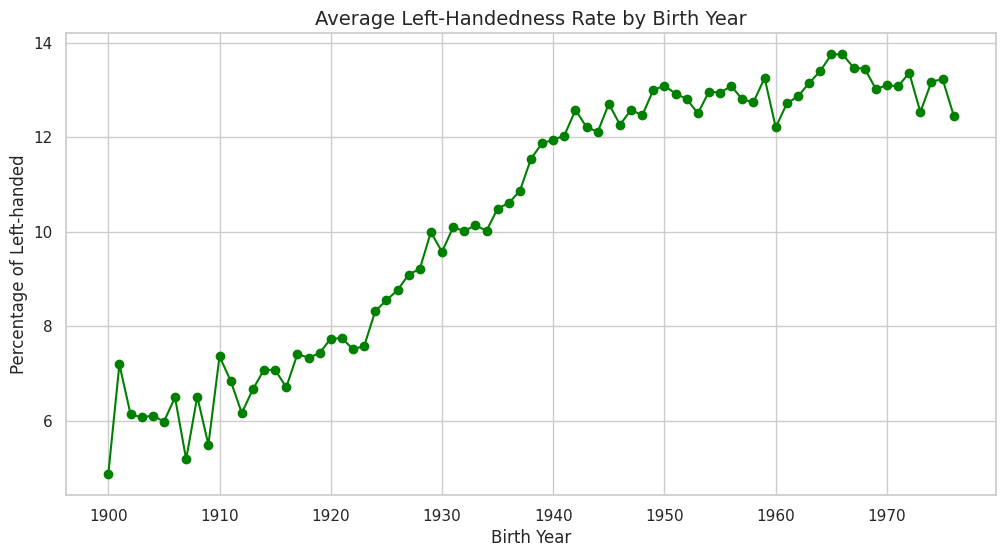

In [45]:
# Create a new column for birth year of each age
lefthanded_data["Birth_year"] = 1986 - lefthanded_data["Age"]

# Create a new column for the average of male and female
lefthanded_data["Mean_lh"] = (lefthanded_data["Male"] + lefthanded_data["Female"]) / 2

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create a plot of the 'Mean_lh' column vs. 'Birth_year'
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting with the style similar to the previous plot
ax.plot("Birth_year", "Mean_lh", data=lefthanded_data, color='green', marker='o', linestyle='-')

# Adding labels and title
ax.set_xlabel("Birth Year", fontsize=12)
ax.set_ylabel("Percentage of Left-handed", fontsize=12)
plt.title("Average Left-Handedness Rate by Birth Year", fontsize=14)

# Display the plot
plt.show()

## 3. Applying Bayes' rule
<p>The probability of dying at a certain age given that you're left-handed is <strong>not</strong> equal to the probability of being left-handed given that you died at a certain age. This inequality is why we need <strong>Bayes' theorem</strong>, a statement about conditional probability which allows us to update our beliefs after seeing evidence. </p>
<p>We want to calculate the probability of dying at age A given that you're left-handed. Let's write this in shorthand as P(A | LH). We also want the same quantity for right-handers: P(A | RH). </p>
<p>Here's Bayes' theorem for the two events we care about: left-handedness (LH) and dying at age A.</p>
<p>$$P(A | LH) = \frac{P(LH|A) P(A)}{P(LH)}$$</p>
<p>P(LH | A) is the probability that you are left-handed <em>given that</em> you died at age A. P(A) is the overall probability of dying at age A, and P(LH) is the overall probability of being left-handed. We will now calculate each of these three quantities, beginning with P(LH | A).</p>
<p>To calculate P(LH | A) for ages that might fall outside the original data, we will need to extrapolate the data to earlier and later years. Since the rates flatten out in the early 1900s and late 1900s, we'll use a few points at each end and take the mean to extrapolate the rates on each end. The number of points used for this is arbitrary, but we'll pick 10 since the data looks flat-ish until about 1910. </p>

In [46]:
# import library
import numpy as np


# create a function for P(LH | A)
def P_lh_given_A(ages_of_death, study_year = 1990):
    """ P(Left-handed | ages of death), calculated based on the reported rates of left-handedness.
    Inputs: numpy array of ages of death, study_year
    Returns: probability of left-handedness given that subjects died in `study_year` at ages `ages_of_death` """

    # Use the mean of the 10 last and 10 first points for left-handedness rates before and after the start
    early_1900s_rate = lefthanded_data['Mean_lh'][-10:].mean()
    late_1900s_rate = lefthanded_data['Mean_lh'][:10].mean()
    middle_rates = lefthanded_data.loc[lefthanded_data['Birth_year'].isin(study_year - ages_of_death)]['Mean_lh']
    youngest_age = study_year - 1986 + 10 # the youngest age is 10
    oldest_age = study_year - 1986 + 86 # the oldest age is 86

    P_return = np.zeros(ages_of_death.shape) # create an empty array to store the results
    # extract rate of left-handedness for people of ages 'ages_of_death'
    P_return[ages_of_death > oldest_age] = early_1900s_rate / 100
    P_return[ages_of_death < youngest_age] = late_1900s_rate / 100
    P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates / 100

    return P_return

## 4. When do people normally die?
<p>To estimate the probability of living to an age A, we can use data that gives the number of people who died in a given year and how old they were to create a distribution of ages of death. If we normalize the numbers to the total number of people who died, we can think of this data as a probability distribution that gives the probability of dying at age A. The data we'll use for this is from the entire US for the year 1999 - the closest I could find for the time range we're interested in. </p>
<p>In this block, we'll load in the death distribution data and plot it. The first column is the age, and the other columns are the number of people who died at that age. </p>

Text(0.5, 1.0, 'Death Distribution by Age in the United States (1999)')

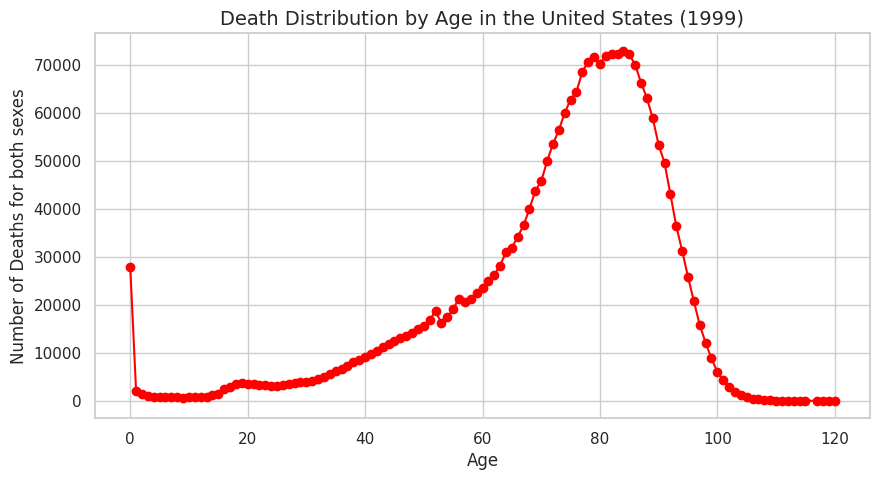

In [47]:
# Death distribution data for the United States in 1999
file2 = "death_US.tsv"

# Load death distribution data
death_distribution_data = pd.read_csv(file2, sep='\t', skiprows=[1])

# Drop NaN values from the `Both Sexes` column
death_distribution_data = death_distribution_data.dropna(subset=["Both Sexes"])


# Plot number of people who died as a function of age
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot('Age', 'Both Sexes', data=death_distribution_data, marker='o', linestyle='-', color='red')

# Setting labels, title, and adjusting label font sizes
ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("Number of Deaths for both sexes", fontsize=12)
plt.title("Death Distribution by Age in the United States (1999)", fontsize=14)

## 5. The overall probability of left-handedness
<p>In the previous code block we loaded data to give us P(A), and now we need P(LH). P(LH) is the probability that a person who died in our particular study year is left-handed, assuming we know nothing else about them. This is the average left-handedness in the population of deceased people, and we can calculate it by summing up all of the left-handedness probabilities for each age, weighted with the number of deceased people at each age, then divided by the total number of deceased people to get a probability. In equation form, this is what we're calculating, where N(A) is the number of people who died at age A (given by the dataframe <code>death_distribution_data</code>):</p>
<p><img src="https://i.imgur.com/gBIWykY.png" alt="equation" width="220"></p>
<!--- $$P(LH) = \frac{\sum_{\text{A}} P(LH | A) N(A)}{\sum_{\text{A}} N(A)}$$ -->

In [48]:
# def P_lh(death_distribution_data, study_year = 1990): # sum over P_lh for each age group
#     """ Overall probability of being left-handed if you died in the study year
#     Input: dataframe of death distribution data, study year
#     Output: P(LH), a single floating point number """
#     p_list = death_distribution_data['Both Sexes'] * P_lh_given_A(death_distribution_data['Age'], study_year) # multiply number of dead people by P_lh_given_A
#     p = np.sum(p_list) # calculate the sum of p_list
#     return p / death_distribution_data['Both Sexes']( # normalize to total number of people (sum of death_distribution_data['Both Sexes'])

# print(P_lh(death_distribution_data))

def P_lh(death_distribution_data, study_year = 1990): # sum over P_lh for each age group
    """ Overall probability of being left-handed if you died in the study year
    P_lh = P(LH | Age of death) P(Age of death) + P(LH | not A) P(not A) = sum over ages
    Input: dataframe of death distribution data
    Output: P(LH), a single floating point number """
    p_list = death_distribution_data['Both Sexes']*P_lh_given_A(death_distribution_data['Age'], study_year)
    p = np.sum(p_list)
    return p/np.sum(death_distribution_data['Both Sexes']) # normalize to total number of people in distribution

print("The overall probability of left-handedness is:", P_lh(death_distribution_data))

The overall probability of left-handedness is: 0.07766387615350638


## 6. Putting it all together: dying while left-handed (i)
<p>Now we have the means of calculating all three quantities we need: P(A), P(LH), and P(LH | A). We can combine all three using Bayes' rule to get P(A | LH), the probability of being age A at death (in the study year) given that you're left-handed. To make this answer meaningful, though, we also want to compare it to P(A | RH), the probability of being age A at death given that you're right-handed. </p>
<p>We're calculating the following quantity twice, once for left-handers and once for right-handers.</p>
<p>$$P(A | LH) = \frac{P(LH|A) P(A)}{P(LH)}$$</p>
<p>First, for left-handers.</p>
<!--Notice that I was careful not to call these "probability of dying at age A", since that's not actually what we're calculating: we use the exact same death distribution data for each. -->

In [49]:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    P_A = death_distribution_data["Both Sexes"][ages_of_death] / death_distribution_data["Both Sexes"].sum()
    P_left = P_lh(death_distribution_data, study_year) # use P_lh function to get probability of left-handedness overall
    P_lh_A = P_lh_given_A(ages_of_death, study_year) # use P_lh_given_A to get probability of left-handedness for a certain age
    return P_lh_A*P_A/P_left


## 7. Putting it all together: dying while left-handed (ii)
<p>And now for right-handers.</p>

In [50]:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    P_A = death_distribution_data["Both Sexes"][ages_of_death] / death_distribution_data["Both Sexes"].sum()
    P_right = 1 - P_lh(death_distribution_data, study_year)# either you're left-handed or right-handed, so P_right = 1 - P_left
    P_rh_A = 1 - P_lh_given_A(ages_of_death, study_year) # P_rh_A = 1 - P_lh_A
    return P_rh_A*P_A/P_right

## 8. Plotting the distributions of conditional probabilities
<p>Now that we have functions to calculate the probability of being age A at death given that you're left-handed or right-handed, let's plot these probabilities for a range of ages of death from 6 to 120. </p>
<p>Notice that the left-handed distribution has a bump below age 70: of the pool of deceased people, left-handed people are more likely to be younger. </p>

Text(0.5, 1.0, 'Probability of Being Left- or Right-Handed at Age of Death')

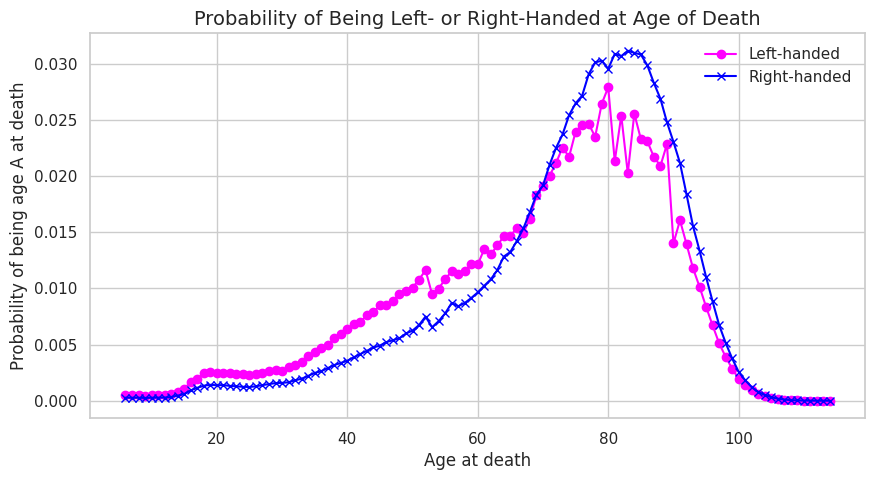

In [51]:

ages = np.arange(6, 115, 1)  # List of ages of death to plot

# Calculate the probabilities
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

# Set seaborn style
sns.set(style="whitegrid")

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ages, left_handed_probability, label="Left-handed", color='magenta', marker='o')
ax.plot(ages, right_handed_probability, label="Right-handed", color='blue', marker='x')
ax.legend()
ax.set_xlabel("Age at death", fontsize=12)
ax.set_ylabel(r"Probability of being age A at death", fontsize=12)
plt.title("Probability of Being Left- or Right-Handed at Age of Death", fontsize=14)

## 9. Moment of truth: age of left and right-handers at death
<p>Finally, let's compare our results with the original study that found that left-handed people were nine years younger at death on average. We can do this by calculating the mean of these probability distributions in the same way we calculated P(LH) earlier, weighting the probability distribution by age and summing over the result.</p>
<p>$$\text{Average age of left-handed people at death} = \sum_A A P(A | LH)$$</p>
<p>$$\text{Average age of right-handed people at death} = \sum_A A P(A | RH)$$</p>

In [52]:
# calculate average ages for left-handed and right-handed groups
# use np.array so that two arrays can be multiplied
average_lh_age =  np.nansum(ages*np.array(left_handed_probability))
average_rh_age =  np.nansum(ages*np.array(right_handed_probability))

# print the average ages for each group
# ... YOUR CODE FOR TASK 9 ...
print("Average age of left-handed people at death: ", average_lh_age)
print("Average age of right-handed people at death: ", average_rh_age)
# print the difference between the average ages
print("The difference in average ages is " + str(round(average_lh_age - average_rh_age, 1)) + " years.")

Average age of left-handed people at death:  67.24503662801027
Average age of right-handed people at death:  72.79171936526477
The difference in average ages is -5.5 years.


## 10. Final comments
<p>We got a pretty big age gap between left-handed and right-handed people purely as a result of the changing rates of left-handedness in the population, which is good news for left-handers: you probably won't die young because of your sinisterness. The reported rates of left-handedness have increased from just 3% in the early 1900s to about 11% today, which means that older people are much more likely to be reported as right-handed than left-handed, and so looking at a sample of recently deceased people will have more old right-handers.</p>
<p>Our number is still less than the 9-year gap measured in the study. It's possible that some of the approximations we made are the cause: </p>
<ol>
<li>We used death distribution data from almost ten years after the study (1999 instead of 1991), and we used death data from the entire United States instead of California alone (which was the original study). </li>
<li>We extrapolated the left-handedness survey results to older and younger age groups, but it's possible our extrapolation wasn't close enough to the true rates for those ages. </li>
</ol>
<p>One thing we could do next is figure out how much variability we would expect to encounter in the age difference purely because of random sampling: if you take a smaller sample of recently deceased people and assign handedness with the probabilities of the survey, what does that distribution look like? How often would we encounter an age gap of nine years using the same data and assumptions? We won't do that here, but it's possible with this data and the tools of random sampling. </p>
<!-- I did do this if we want to add more tasks - it would probably take three more blocks.-->
<p>To finish off, let's calculate the age gap we'd expect if we did the study in 2018 instead of in 1990. The gap turns out to be much smaller since rates of left-handedness haven't increased for people born after about 1960. Both the National Geographic study and the 1990 study happened at a unique time - the rates of left-handedness had been changing across the lifetimes of most people alive, and the difference in handedness between old and young was at its most striking. </p>

In [53]:
# Calculate the probability of being left- or right-handed for all ages
left_handed_probability_2018 = P_A_given_lh(ages, death_distribution_data, 2018)
right_handed_probability_2018 = P_A_given_rh(ages, death_distribution_data, 2018)

# calculate average ages for left-handed and right-handed groups
average_lh_age_2018 = np.nansum(ages*np.array(left_handed_probability_2018))
average_rh_age_2018 = np.nansum(ages*np.array(right_handed_probability_2018))

print("The difference in average ages is " +
      str(round(average_lh_age_2018- average_rh_age_2018, 1)) + " years.")

The difference in average ages is -2.3 years.
